wait for fill

> Step 0. Introduction - Importing libraries and loading data

> Step 1. Data analysis and preprocessing

> Step 2. Model selection

> Step 3. Model training

> Step 4. Model evaluation

> Step 5. Model prediction

> Step 6. Model submission

> Step 7. Conclusion

First, import the necessary libraries section.

In [18]:
# Python library
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import yaml
import albumentations as A

from glob import glob
from tqdm import tqdm
from PIL import Image
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor

# Sklearn library
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Pytorch library
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# CV2 library
import cv2

In [19]:
# Load configuration
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Project information
print('Project name: ', config['project']['name'])
print('Project version: ', config['project']['description'])
print('Project author: ', config['project']['version'])

# Data location
print('Data path: ', config['data'])
data_path = config['data']['data_path']
csv_path = config['data']['csv_path']
images_path = config['data']['images_path']
n_workers = config['training']['n_workers']
batch_size = config['training']['batch_size']
print('N workers: ', n_workers)
print('Batch size: ', batch_size)

# Preprocessing configuration
print('Preprocessing configuration')
augmentation_ratio = config['preprocessing']['augmentation']['ratio']
print('Augmentation ratios: ', augmentation_ratio)

# Create a dictionary for images location
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Project name:  Cancer Detection
Project version:  DPL302m Project - Fall 2024 of Group 1
Project author:  1.0.0
Data path:  {'data_path': 'data/', 'csv_path': 'data/HAM10000_metadata.csv', 'images_path': 'data/images/'}
N workers:  16
Batch size:  32
Preprocessing configuration
Augmentation ratios:  2


In [20]:
# Data reading
data = pd.read_csv(csv_path)

In [21]:
def data_check(data):
    # Show data types
    print('Data types:')
    print(data.dtypes)
    print()
    
    # Show unique values for each column (skip image_id and lesion_id)
    print('Unique values for each column:')
    for col in data.columns:
        if col in ['image_id', 'lesion_id']:
            continue
        print(f"{col}: {data[col].unique()[:5]}...")  # Hiển thị một vài giá trị đầu
    print()
    
    # Count NaN values
    print('NaN values in each column:')
    nan_counts = data.isnull().sum()
    print(nan_counts[nan_counts > 0])
    print()
    
    # Count 'unknown' values (only for object columns)
    print('Unknown values in each column:')
    for col in data.select_dtypes(include=['object']).columns:
        unknown_count = data[data[col] == 'unknown'].shape[0]
        if unknown_count > 0:
            print(f"{col}: {unknown_count}")
    print()
    
    # Summary
    print("Summary of potential data issues:")
    print(f"- Columns with NaN values: {nan_counts[nan_counts > 0].index.tolist()}")
    print(f"- Columns with 'unknown' values: {[col for col in data.columns if 'unknown' in data[col].values]}")



In [22]:
data_check(data)

Data types:
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

Unique values for each column:
dx: ['bkl' 'nv' 'df' 'mel' 'vasc']...
dx_type: ['histo' 'consensus' 'confocal' 'follow_up']...
age: [80. 75. 60. 70. 55.]...
sex: ['male' 'female' 'unknown']...
localization: ['scalp' 'ear' 'face' 'back' 'trunk']...

NaN values in each column:
age    57
dtype: int64

Unknown values in each column:
sex: 57
localization: 234

Summary of potential data issues:
- Columns with NaN values: ['age']
- Columns with 'unknown' values: ['sex', 'localization']


In [23]:
def data_cleaning(data):
    # Drop duplicates defined by 'image_id' and 'lesion_id'
    data = data.drop_duplicates(subset=['image_id', 'lesion_id'])
    
    # Drop values with NaN
    data = data.dropna(subset=['age', 'sex', 'localization'])
    data = data[data['age'] != 'unknown']
    data = data[data['sex'] != 'unknown']
    data = data[data['localization'] != 'unknown']

    # Convert 'age' to int
    try:
        data['age'] = data['age'].astype(int)
    except ValueError:
        print("Some 'age' values could not be converted to int.")
    
    # Create label encoders for each categorical column
    label_encoder_dx = LabelEncoder()
    label_encoder_dx_type = LabelEncoder()
    label_encoder_sex = LabelEncoder()
    label_encoder_localization = LabelEncoder()

    # Encode labels
    data['dx_code'] = label_encoder_dx.fit_transform(data['dx'])
    data['dx_type_code'] = label_encoder_dx_type.fit_transform(data['dx_type'])
    data['sex_code'] = label_encoder_sex.fit_transform(data['sex'])
    data['localization_code'] = label_encoder_localization.fit_transform(data['localization'])

    # Add location of images
    data['image_id'] = data['image_id'].apply(lambda x: os.path.join(images_path, x + '.jpg'))

    print('Data after cleaning:')
    print(data.head())

    data = data.reset_index(drop=True)

    return data

In [24]:
data = data_cleaning(data)
data_check(data)

Data after cleaning:
     lesion_id                      image_id   dx dx_type  age   sex  \
0  HAM_0000118  data/images/ISIC_0027419.jpg  bkl   histo   80  male   
1  HAM_0000118  data/images/ISIC_0025030.jpg  bkl   histo   80  male   
2  HAM_0002730  data/images/ISIC_0026769.jpg  bkl   histo   80  male   
3  HAM_0002730  data/images/ISIC_0025661.jpg  bkl   histo   80  male   
4  HAM_0001466  data/images/ISIC_0031633.jpg  bkl   histo   75  male   

  localization  dx_code  dx_type_code  sex_code  localization_code  
0        scalp        2             3         1                 11  
1        scalp        2             3         1                 11  
2        scalp        2             3         1                 11  
3        scalp        2             3         1                 11  
4          ear        2             3         1                  4  
Data types:
lesion_id            object
image_id             object
dx                   object
dx_type              object
age     

In [25]:
def split_data(data, test_size=0.2, random_state=42):
    # Split data into training and testing sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
    print("Train data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)

    return train_data, test_data

In [26]:
train_data, test_data = split_data(data, config['training']['test_size'], config['training']['random_state'])

Train data shape: (7808, 11)
Test data shape: (1953, 11)


In [27]:
def process_batch1(batch):
    images = []
    for index, row in batch.iterrows():
        image_path = row['image_id']  # Sử dụng đường dẫn đầy đủ từ image_id
        image = cv2.imread(image_path)
        if image is None:
            print('Image not found: ', image_path)
            continue
        # Preprocess image
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return images

def load_images(data, batch_size=32, num_workers=4):
    all_images = []
    batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    st = time.time()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(process_batch1, batch): batch for batch in batches}

        for future in tqdm(as_completed(futures), total=len(futures)):
            img_batch = future.result()
            if img_batch is not None:
                all_images.extend(img_batch)
    et = time.time()
    print('Loaded {} images in {} seconds'.format(len(all_images), et - st))
    return all_images

In [28]:
# Load train images
images = load_images(data, batch_size=batch_size, num_workers=n_workers)

100%|██████████| 306/306 [00:08<00:00, 36.89it/s]


Loaded 9761 images in 8.331885576248169 seconds


In [29]:
def type_count(data, rate):
    lesion_type = data.groupby(data['dx']).count()
    lesion_type = lesion_type.reset_index()
    lesion_type = lesion_type[['dx', 'image_id']]
    lesion_type.columns = ['dx', 'count']
    lesion_type = lesion_type.sort_values(by='count', ascending=False)
    print(lesion_type)
    max_count = lesion_type['count'].max()
    augmentation_counts = {}
    for index, row in lesion_type.iterrows():
        augmentation_counts[row['dx']] = int(max_count / row['count'] * rate)
    return augmentation_counts

In [30]:
augmentation_counts = type_count(train_data, config['preprocessing']['augmentation']['ratio'])
print("Augmentation Ratios:", augmentation_counts)
_ = type_count(test_data, 0)

      dx  count
5     nv   5205
4    mel    876
2    bkl    849
1    bcc    404
0  akiec    265
6   vasc    120
3     df     89
Augmentation Ratios: {'nv': 2, 'mel': 11, 'bkl': 12, 'bcc': 25, 'akiec': 39, 'vasc': 86, 'df': 116}
      dx  count
5     nv   1286
2    bkl    227
4    mel    225
1    bcc    105
0  akiec     62
3     df     26
6   vasc     22


In [31]:
def augment_images(data, images_array, augmentation_counts):
    # Define augmentations by albumentations library
    augmentations = A.Compose([
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        A.Rotate(limit=(90, 90), p=0.25),
        A.Rotate(limit=(180, 180), p=0.25),  
        A.Rotate(limit=(270, 270), p=0.25),  
          A.RandomBrightnessContrast(brightness_limit=(0.1, 0.1), contrast_limit=(0.1, 0.1), p=0.25),
        ])
    
    print(f'Number of images: {len(images_array)}, Number of rows in data: {len(data)}')
    augmented_images = []
    augmented_data = []

    for index, row in data.iterrows():
        lesion_type = row['dx']
        count = augmentation_counts.get(lesion_type, 0)
        if count == 0:
            continue
        
        image = images_array[index]
        
        for _ in range(count):
            if _ == 0:
                augmented_images.append(image)
                augmented_row = row.copy()
                augmented_row['image_id'] = row['image_id'] + '_original'
                augmented_data.append(augmented_row)
                continue
            
            augment_image = augmentations(image=image)
            augmented_images.append(augment_image['image'])
            augmented_row = row.copy()
            augmented_row['image_id'] = row['image_id'] + '_augmented_' + str(_)
            augmented_data.append(augmented_row)
            
    augmented_data = pd.DataFrame(augmented_data)
    return augmented_data, augmented_images

In [32]:
def augment_image_worker(row, image, augmentations, augmentation_counts):
    augmented_images = []
    augmented_data = []
    
    lesion_type = row['dx']
    count = augmentation_counts.get(lesion_type, 0)
    if count == 0:
        return None, None
    
    for _ in range(count):
        if _ == 0:
            augmented_images.append(image)
            augmented_row = row.copy()
            augmented_row['image_id'] = row['image_id'] + '_original'
            augmented_data.append(augmented_row)
            continue
        
        augment_image = augmentations(image=image)
        augmented_images.append(augment_image['image'])
        augmented_row = row.copy()
        augmented_row['image_id'] = row['image_id'] + '_augmented_' + str(_)
        augmented_data.append(augmented_row)
    
    return augmented_data, augmented_images

def augment_images(data, images_array, augmentation_counts, num_workers=4):
    # Define augmentations by albumentations library
    augmentations = A.Compose([
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        A.Rotate(limit=(90, 90), p=0.25),
        A.Rotate(limit=(180, 180), p=0.25),  
        A.Rotate(limit=(270, 270), p=0.25),  
        A.RandomBrightnessContrast(limit=(0.1,0.1), p=0.25),
    ])
    
    print(f'Number of images: {len(images_array)}, Number of rows in data: {len(data)}')
    
    augmented_images = []
    augmented_data = []
    
    # Use ThreadPoolExecutor to parallelize the augmentation process
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        
        # Send each row and image to worker function
        for index, row in tqdm(data.iterrows(), total=len(data), desc="Augmenting Images"):
            futures.append(
                executor.submit(augment_image_worker, row, images_array[index], augmentations, augmentation_counts)
            )
        
        # Collect results from futures
        for future in tqdm(as_completed(futures), total=len(futures), desc="Collecting Results"):
            aug_data, aug_images = future.result()
            if aug_data is not None and aug_images is not None:
                augmented_data.extend(aug_data)
                augmented_images.extend(aug_images)
    
    # Convert to DataFrame
    augmented_data = pd.DataFrame(augmented_data)
    
    return augmented_data, augmented_images


In [33]:
augmented_train_data, augmented_train_images = augment_images(train_data, images, augmentation_counts)
print('Train data shape: ', train_data.shape)
print('Augmented data shape: ', augmented_train_data.shape)
print('Augmented images length: ', len(augmented_train_images))

C:\Users\fxlqt\AppData\Local\Temp\ipykernel_12300\2671146945.py:34: UserWarning: Argument 'limit' is not valid and will be ignored.
  A.RandomBrightnessContrast(limit=(0.1,0.1), p=0.25),


Number of images: 9761, Number of rows in data: 7808
Train data shape:  (7808, 11)
Augmented data shape:  (71313, 11)
Augmented images length:  71313


In [16]:
def process_batch2(batch_paths):
    img_w, img_h = 224, 224
    batch_imgs = []

    for path in batch_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (img_w, img_h))
            batch_imgs.append(img)

    return np.array(batch_imgs)

def compute_img_mean_std(image_paths, batch_size=32, num_workers=4):
    imgs = []
    means, stdevs = [], []
    batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]

    st = time.time()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(process_batch2, batch): batch for batch in batches}
        for future in tqdm(as_completed(futures), total=len(futures)):
            img_batch = future.result()
            if img_batch is not None:
                imgs.extend(img_batch)
    et = time.time()

    print("Loaded {images} images".format(images=len(imgs)), "in: {time:.2f} seconds.".format(time=et - st))
    imgs = np.stack(imgs, axis=0)
    print(f"Stacked images shape: {imgs.shape}")
    
    imgs = imgs.astype(np.float32) / 255.0
    for i in range(3):
        pixels = imgs[:, :, :, i].ravel()
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()
    stdevs.reverse()

    return means, stdevs


In [17]:
# Return the mean and std of the images
images_path_list = data['image_id'].tolist()
print('Number of images: ', len(images_path_list))
norm_means, norm_stdevs = compute_img_mean_std(images_path_list, batch_size=batch_size, num_workers=n_workers)
#means, stdevs = compute_img_mean_std(images_path_list)
print('Normed means: ', norm_means)
print('Normed stds: ', norm_stdevs)

Number of images:  9761


100%|██████████| 306/306 [00:05<00:00, 51.49it/s]


Loaded 9761 images in: 5.98 seconds.
Stacked images shape: (9761, 224, 224, 3)
Normed means:  [np.float32(0.76392394), np.float32(0.54433286), np.float32(0.5681715)]
Normed stds:  [np.float32(0.14101331), np.float32(0.15212949), np.float32(0.16933376)]


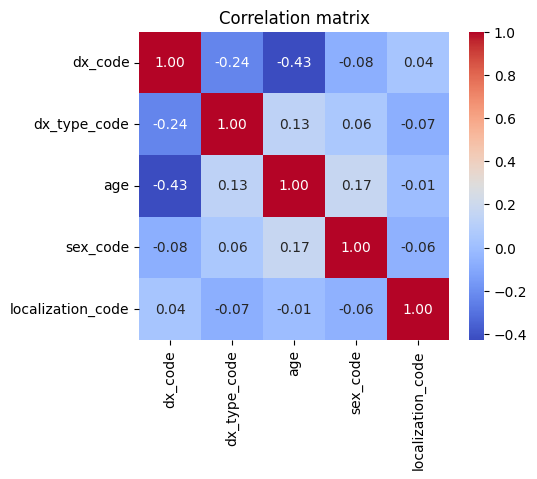

In [18]:
# Correlation matrix checkings
# Select columns to check
# lesion_id,image_id,dx,dx_type,age,sex,localization
columns = ['dx_code', 'dx_type_code','age','sex_code','localization_code']
data_corr = data[columns]
# Compute the correlation matrix
corr = data_corr.corr()
# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()